# Finding the MRI brain tumor detection dataset

Let's find the dataset in this link: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# Import packages

In [13]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

# Image Reading

In [15]:
tumor = []
healthy = []
for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [16]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [17]:
healthy.shape

(91, 128, 128, 3)

In [18]:
tumor.shape

(154, 128, 128, 3)

In [19]:
np.random.choice(10, 5, replace=False)

array([8, 4, 6, 0, 7])

# MRI Image Visualization 

In [21]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])
        
        

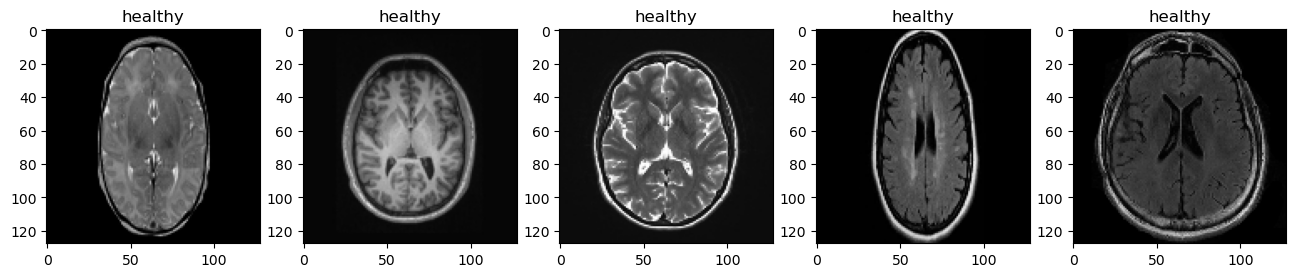

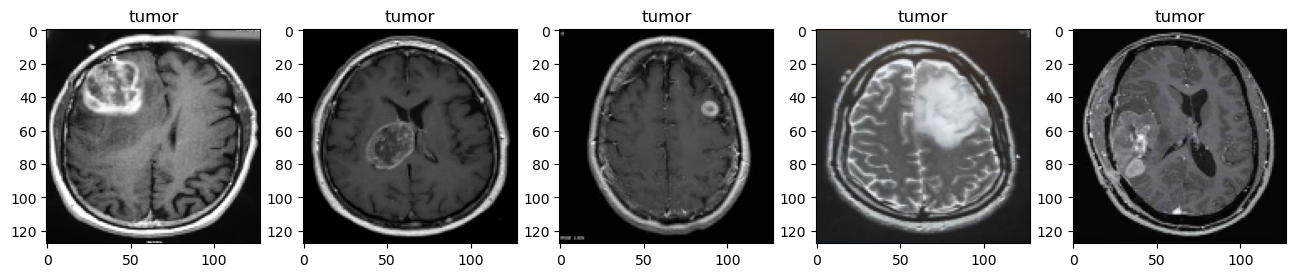

In [22]:
plot_random(healthy, tumor, num=5)

# Creating Torch Dataset Class

# Pytorch's Abstract Dataset Class

In [26]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

# Creating MRI cutom dataset class

In [34]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0


In [36]:
mri_dataset = MRI()
mri_dataset.normalize()

# Creating a dataloader

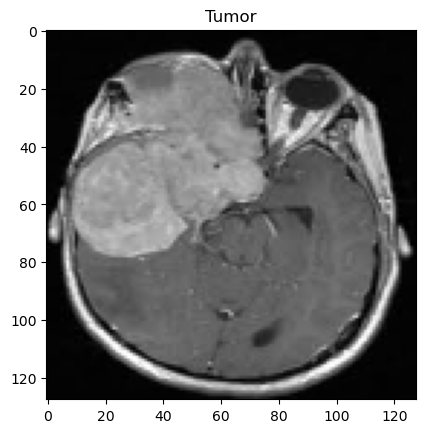

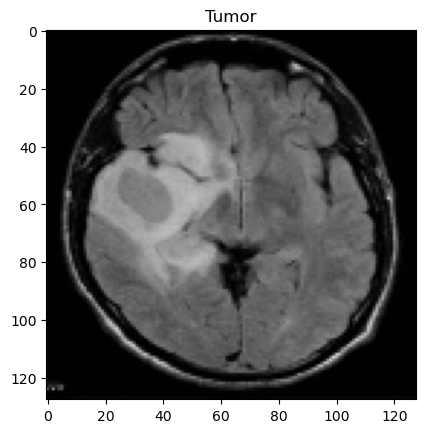

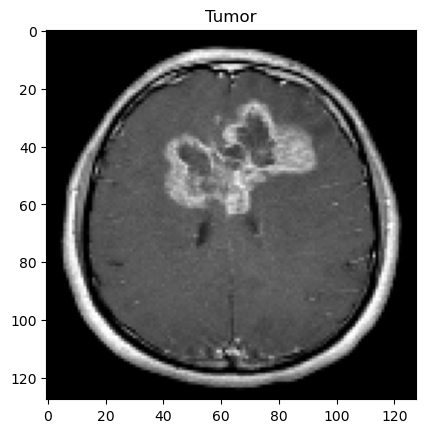

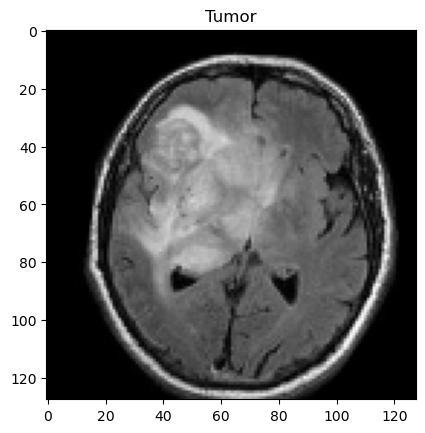

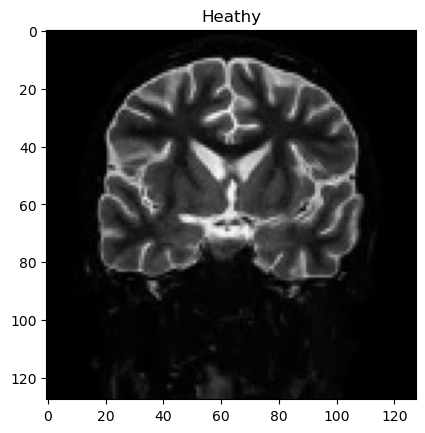

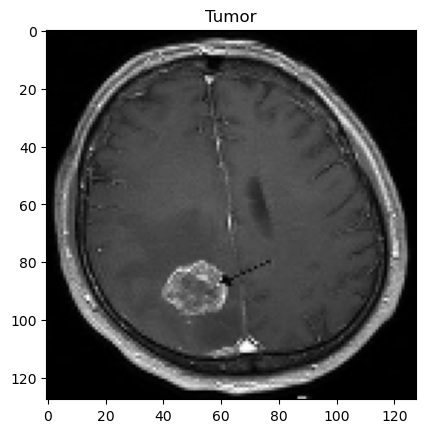

In [40]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# Create a model

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

# Some Basics of Training and Evaluation in Pytorch

# model.eval()

Used particularly for inference NOTHING to DO with gradients!!!
changes the forward() behaviour of the module it is called up on eg, it disables dropout and has batch norm use the entire population statistics. This is necessary for inference

In [46]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu:0')
model = CNN().to(device)

In [47]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [50]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    

In [52]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [54]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [56]:
accuracy_score(y_true, threshold(outputs))

0.37142857142857144

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

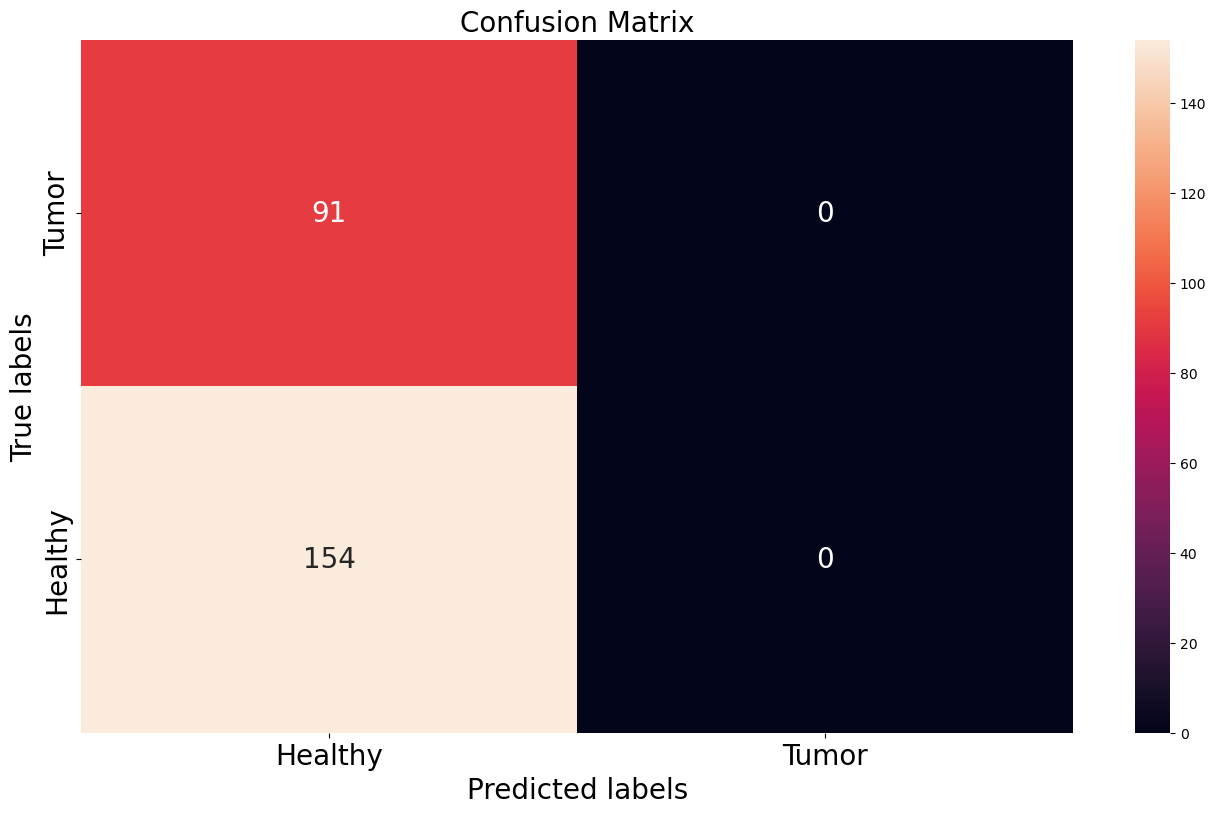

In [58]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

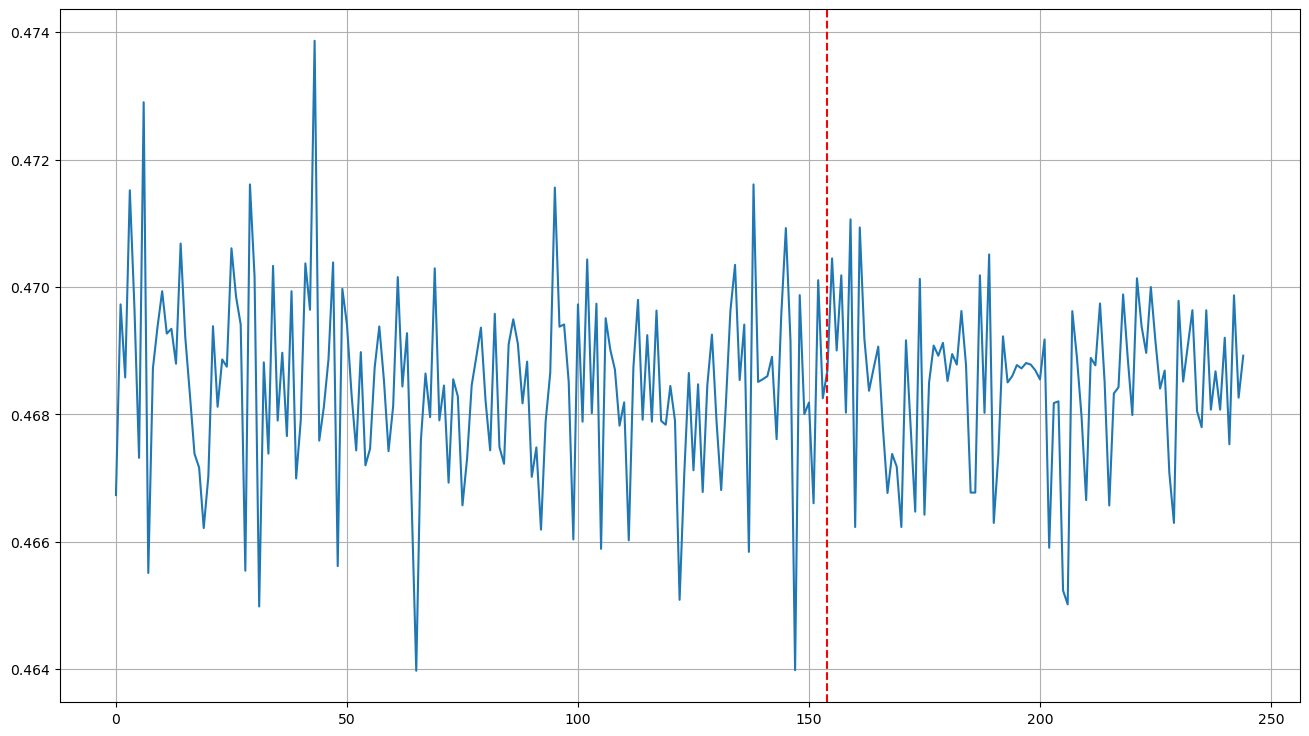

In [59]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [62]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [63]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.623353
Train Epoch: 20	Loss: 0.596503
Train Epoch: 30	Loss: 0.561741
Train Epoch: 40	Loss: 0.550702
Train Epoch: 50	Loss: 0.534734
Train Epoch: 60	Loss: 0.514748
Train Epoch: 70	Loss: 0.502192
Train Epoch: 80	Loss: 0.493302
Train Epoch: 90	Loss: 0.470851
Train Epoch: 100	Loss: 0.452247
Train Epoch: 110	Loss: 0.439508
Train Epoch: 120	Loss: 0.432317
Train Epoch: 130	Loss: 0.415724
Train Epoch: 140	Loss: 0.396968
Train Epoch: 150	Loss: 0.392310
Train Epoch: 160	Loss: 0.369124
Train Epoch: 170	Loss: 0.365547
Train Epoch: 180	Loss: 0.365876
Train Epoch: 190	Loss: 0.330783
Train Epoch: 200	Loss: 0.320187
Train Epoch: 210	Loss: 0.304532
Train Epoch: 220	Loss: 0.295748
Train Epoch: 230	Loss: 0.269451
Train Epoch: 240	Loss: 0.247211
Train Epoch: 250	Loss: 0.245577
Train Epoch: 260	Loss: 0.225451
Train Epoch: 270	Loss: 0.216263
Train Epoch: 280	Loss: 0.199398
Train Epoch: 290	Loss: 0.178884
Train Epoch: 300	Loss: 0.166382
Train Epoch: 310	Loss: 0.145430
Train Epoch: 320	

# Evaluate a smart model

In [65]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [66]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

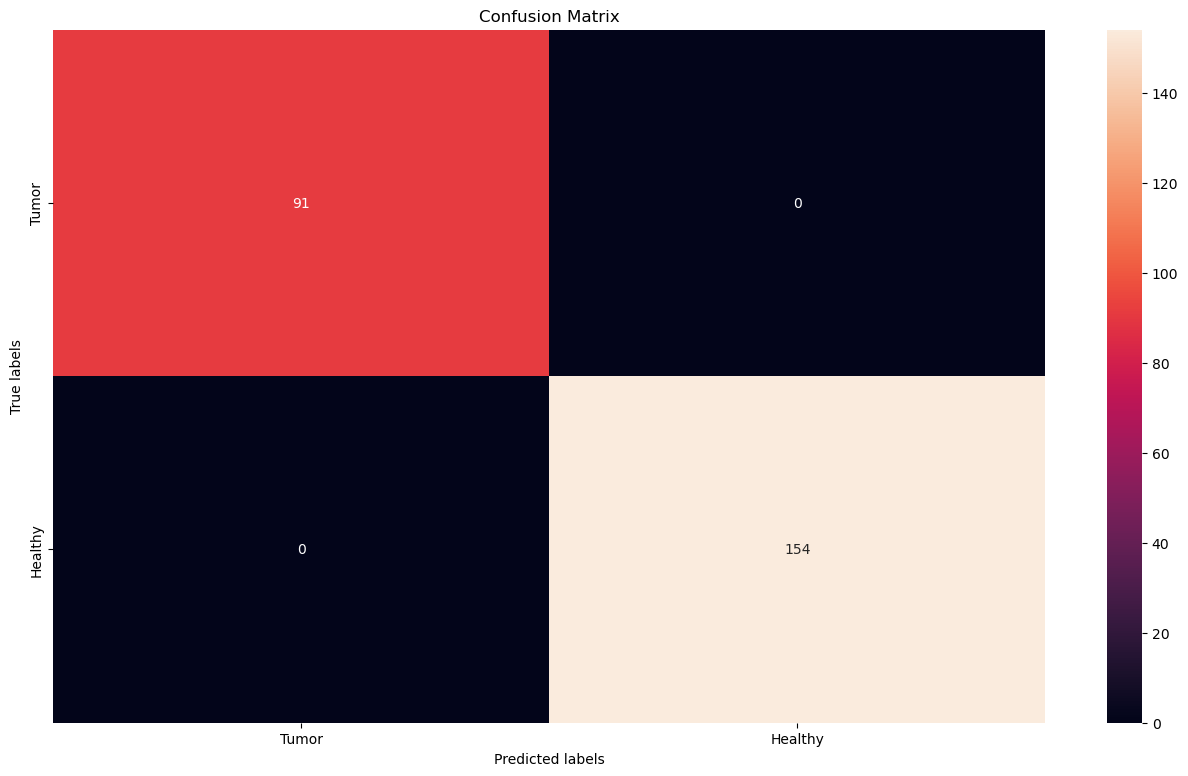

In [67]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

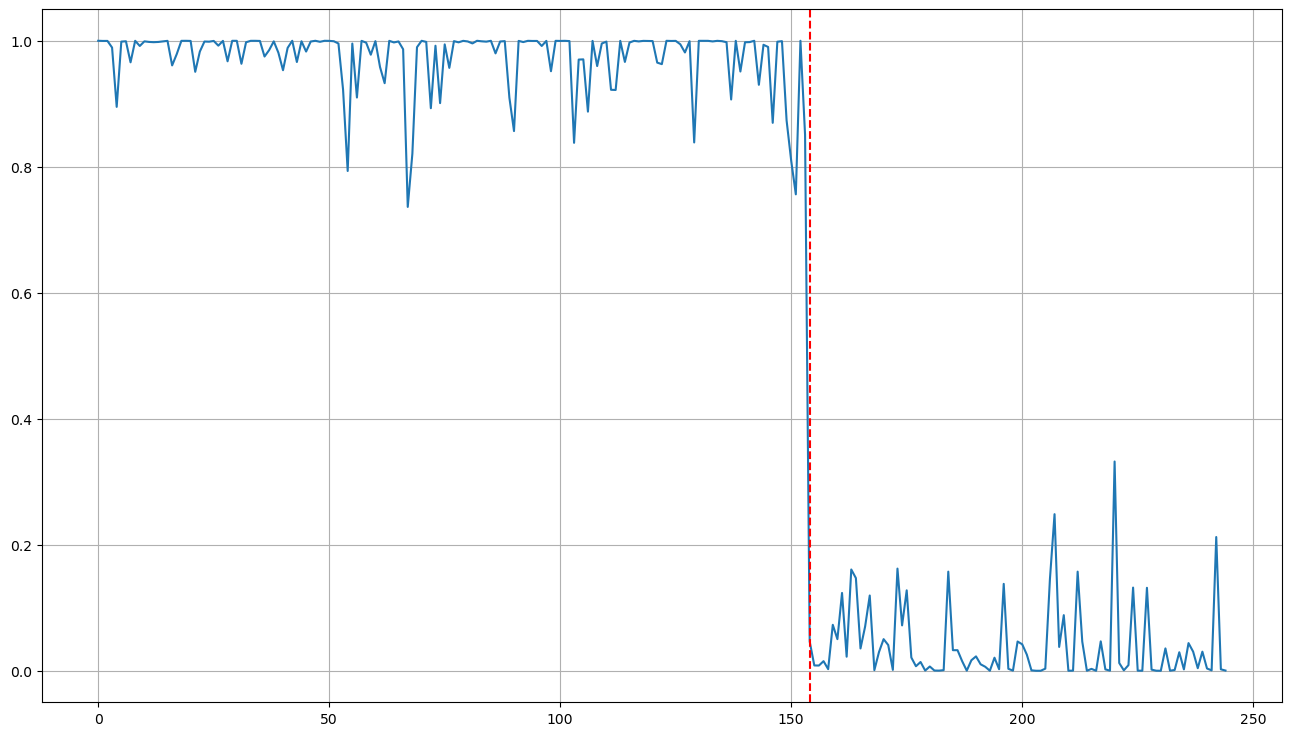

In [68]:

plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Visualising the Feature Maps of the Convolutional Filters

In [71]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [63]:
no_of_layers = 0
conv_layers = []

In [64]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [65]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [66]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

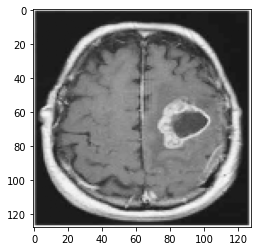

In [64]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [65]:
img = torch.from_numpy(img).to(device)

In [66]:
img.shape

torch.Size([3, 128, 128])

In [67]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [68]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


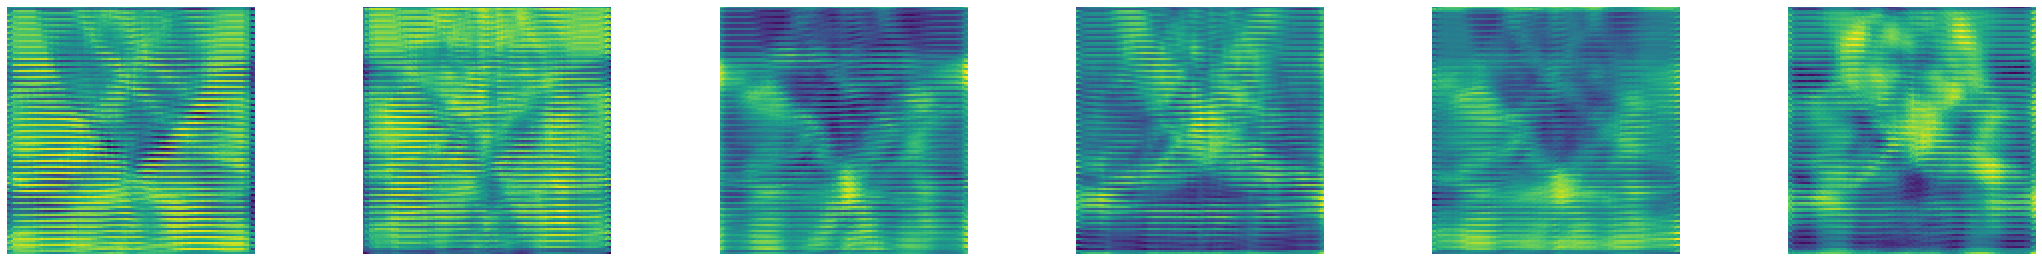

Layer  2


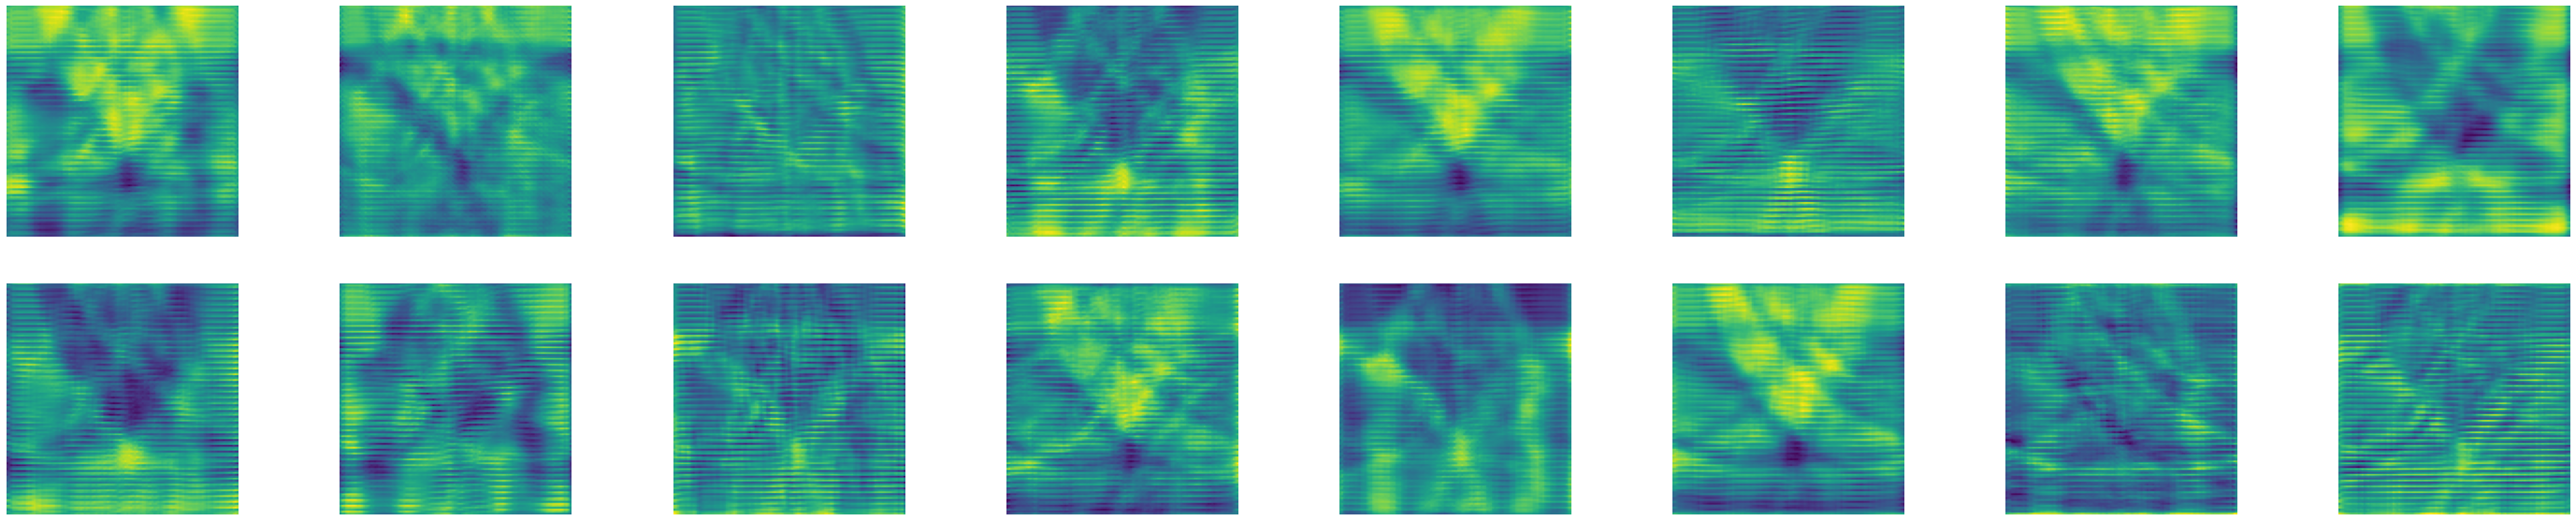

In [69]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

# Preparing a validation set: We need to change the MRI dataset slightly!

In [95]:
from sklearn.model_selection import train_test_split

In [110]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)
              # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]

    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0
    



In [112]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [114]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [116]:
device = torch.device("cuda:0")
model = CNN().to(device)

In [118]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [120]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [126]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

Train Epoch: 10	Train Loss: 0.653606	Val Loss: 0.596572
Train Epoch: 20	Train Loss: 0.607382	Val Loss: 0.575429
Train Epoch: 30	Train Loss: 0.528020	Val Loss: 0.525996
Train Epoch: 40	Train Loss: 0.491803	Val Loss: 0.527987
Train Epoch: 50	Train Loss: 0.516515	Val Loss: 0.533479
Train Epoch: 60	Train Loss: 0.553220	Val Loss: 0.529131
Train Epoch: 70	Train Loss: 0.489589	Val Loss: 0.550690
Train Epoch: 80	Train Loss: 0.551856	Val Loss: 0.555170
Train Epoch: 90	Train Loss: 0.547230	Val Loss: 0.557635
Train Epoch: 100	Train Loss: 0.458950	Val Loss: 0.553879
Train Epoch: 110	Train Loss: 0.519810	Val Loss: 0.555401
Train Epoch: 120	Train Loss: 0.427822	Val Loss: 0.585905
Train Epoch: 130	Train Loss: 0.422335	Val Loss: 0.593119
Train Epoch: 140	Train Loss: 0.424237	Val Loss: 0.631885
Train Epoch: 150	Train Loss: 0.397391	Val Loss: 0.639833
Train Epoch: 160	Train Loss: 0.446344	Val Loss: 0.668838
Train Epoch: 170	Train Loss: 0.379710	Val Loss: 0.684871
Train Epoch: 180	Train Loss: 0.391843	Va

Text(0, 0.5, 'Loss')

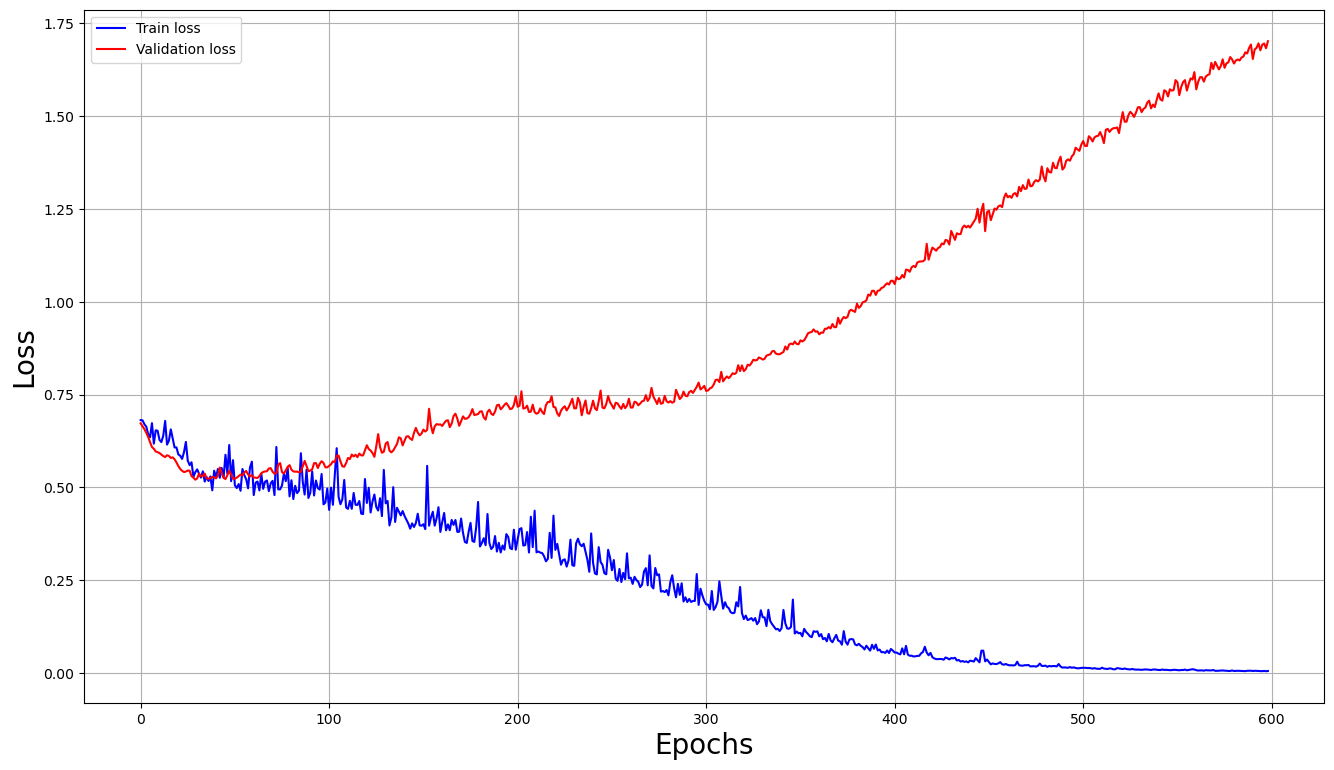

In [127]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)